<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/PretrainedModelsTensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Computer Vision Using Tensorflow
## Pretrained Models for Transfer Learning

# Setup

This project requires Python 3.7 or above:

In [2]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [4]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [32]:
import numpy as np

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [6]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")

No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


# Using Pretrained Models from Keras

In [9]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [7]:
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
images = load_sample_images()["images"]
images_resized = []
for image in images:
  resized_image = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(image)
  images_resized.append(resized_image)

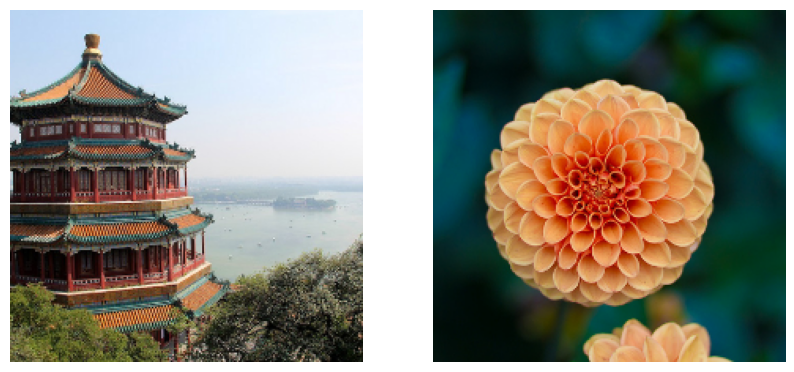

In [17]:
# extra code – displays the cropped and resized images

plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

In [18]:
# Convert the list of images to a tensor
images_resized = tf.convert_to_tensor(images_resized)

# Preprocess the images
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [19]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


(2, 1000)

In [20]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)

Image #0


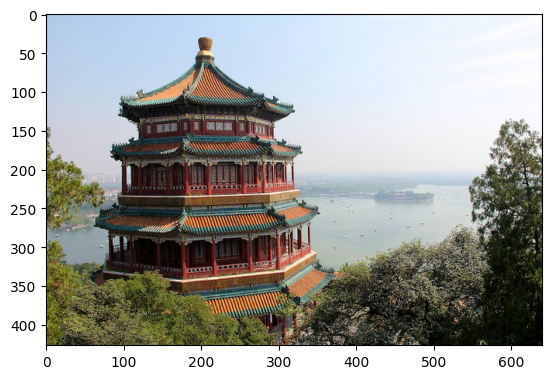

  n03598930 - jigsaw_puzzle 38.05%
  n02782093 - balloon      14.30%
  n03877845 - palace       4.83%
Image #1


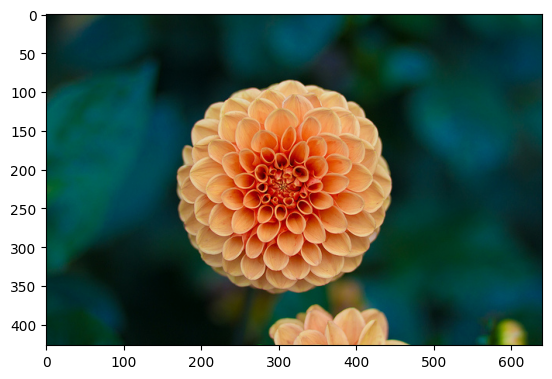

  n04209133 - shower_cap   18.77%
  n02782093 - balloon      12.99%
  n09229709 - bubble       11.91%


In [21]:
for image_index in range(0, len(images)):
    print(f"Image #{image_index}")

    # Display the original image
    plt.imshow(images[image_index])
    plt.show()

    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

# Pretrained Models for Transfer Learning

In [22]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [23]:
dataset_size

3670

In [24]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [25]:
n_classes

5

In [26]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

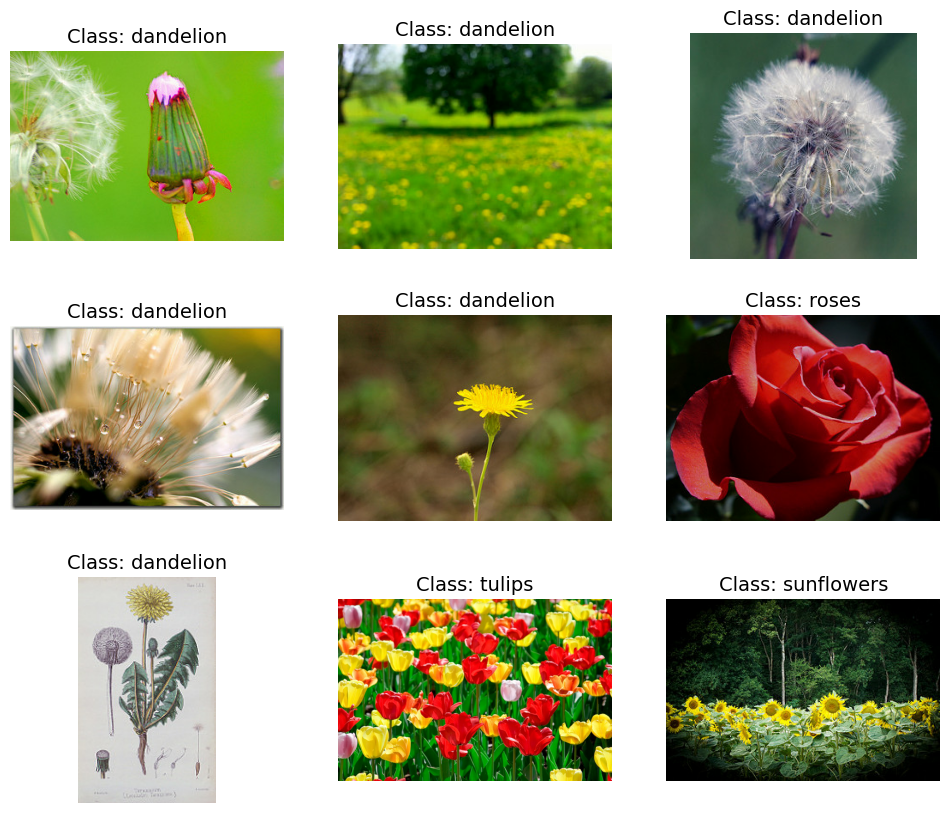

In [27]:
# extra code – displays the first 9 images in the validation set

plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a `Resizing` layer for this. We must also call the `tf.keras.applications.xception.preprocess_input()` function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [28]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Let's take a look again at the first 9 images from the validation set: they're all 224x224 now, with values ranging from -1 to 1:

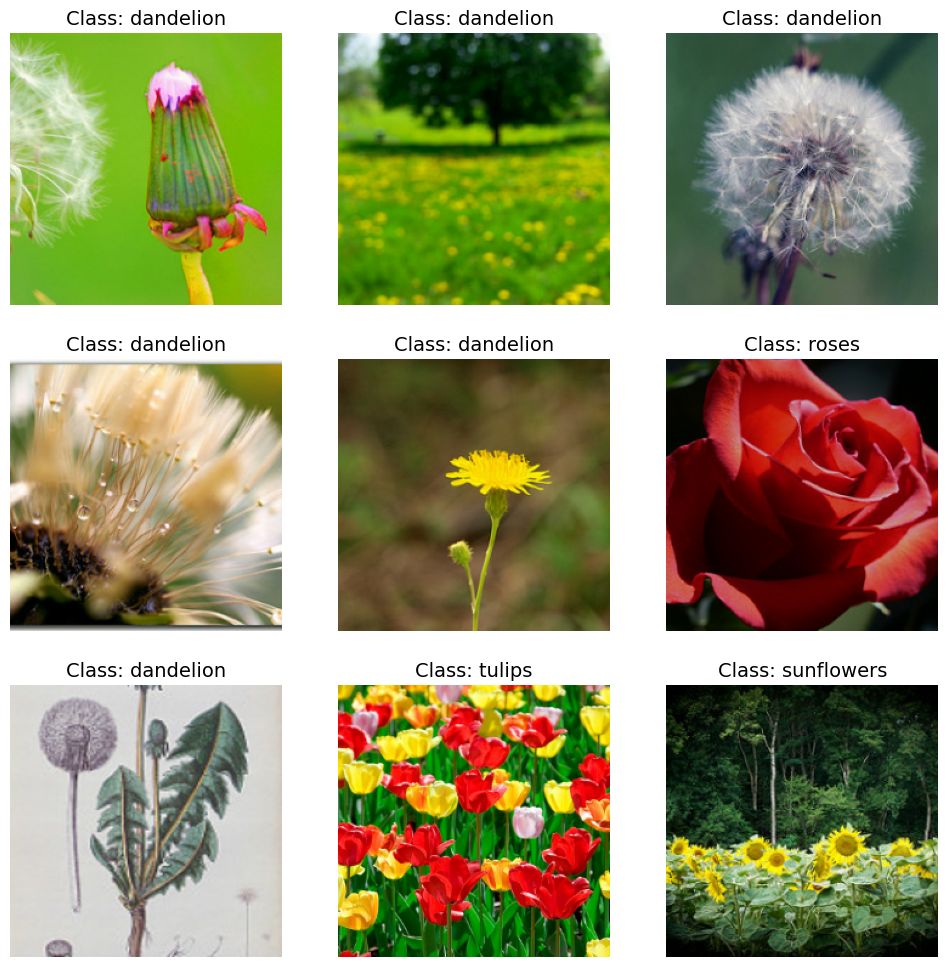

In [29]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [30]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

Try running the following cell multiple times to see different random data augmentations:

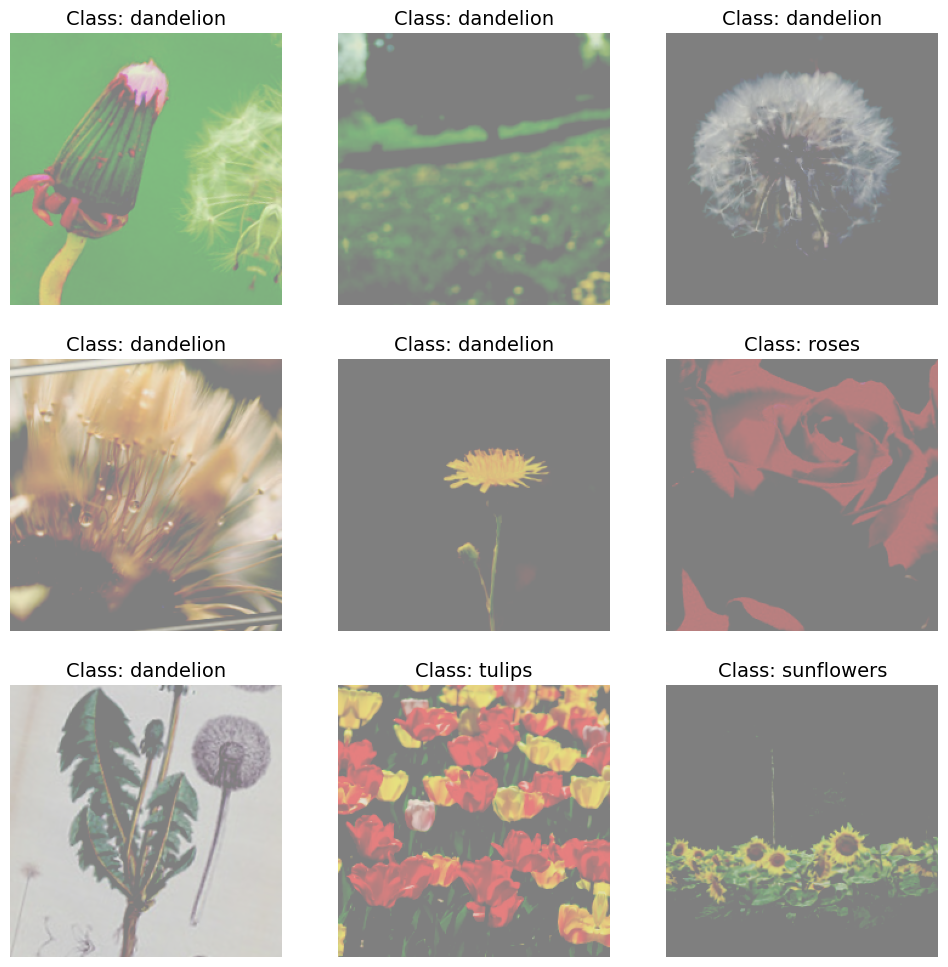

In [35]:
# extra code – displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

Now let's load the pretrained model, without its top layers, and replace them with our own, for the flower classification task:

In [36]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [37]:
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [38]:
for layer in base_model.layers:
    layer.trainable = False

Let's train the model for a few epochs, while keeping the base model weights fixed:

In [39]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 725s 8s/step - accuracy: 0.7124 - loss: 1.0149 - val_accuracy: 0.8421 - val_loss: 0.6324
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 724s 8s/step - accuracy: 0.8938 - loss: 0.4545 - val_accuracy: 0.8494 - val_loss: 0.8160
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 720s 8s/step - accuracy: 0.9437 - loss: 0.1842 - val_accuracy: 0.8766 - val_loss: 0.5890


In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_2          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again, and continue training, but with a lower learning rate:

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 47s 313ms/step - accuracy: 0.8787 - loss: 0.4234 - val_accuracy: 0.8566 - val_loss: 0.6481
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 278ms/step - accuracy: 0.9842 - loss: 0.0523 - val_accuracy: 0.8966 - val_loss: 0.3761
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 272ms/step - accuracy: 0.9921 - loss: 0.0241 - val_accuracy: 0.8966 - val_loss: 0.3992
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 269ms/step - accuracy: 0.9924 - loss: 0.0218 - val_accuracy: 0.8984 - val_loss: 0.4328
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 272ms/step - accuracy: 0.9951 - loss: 0.0099 - val_accuracy: 0.8966 - val_loss: 0.4166
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step - accuracy: 0.9962 - loss: 0.0148 - val_accuracy: 0.9002 - val_loss: 0.4134
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step - accuracy: 0.9986 - loss: 0.0053 - val_accuracy: 0.8984 - val_loss: 0.4207
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 272ms/step - accuracy: 0.9977 - loss: 0.0065 - val_accu